# "Grammarly" for inter-model text-image synthesis
## Overview

In this notebook, we briefly demonstrate how we could tune a trained text prompt auto completion model (GPT-2 model finetuned on the text-image synthesis dataset) to adapt it from MidJourney to the open-source Stable Diffusion model.

## Menu

1. preparations
2. build the text-image pair data given the json file from [https://www.kaggle.com/datasets/succinctlyai/midjourney-texttoimage](https://www.kaggle.com/datasets/succinctlyai/midjourney-texttoimage)
3. build the pipeline for the Stable Diffusion.
4. start training!
5. some results comparing the generation between MidJourney & Stable Diffusion

## 1. Preparations

In [ ]:
# mount the drive to load model parameters
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install packages
!pip install datasets transformers --q
!pip install -qq diffusers["training"]==0.4.1 transformers ftfy --q

     |████████████████████████████████| 451 kB 3.7 MB/s 
     |████████████████████████████████| 5.5 MB 96.4 MB/s 
     |████████████████████████████████| 115 kB 89.6 MB/s 
     |████████████████████████████████| 182 kB 3.6 MB/s 
     |████████████████████████████████| 212 kB 88.4 MB/s 
     |████████████████████████████████| 127 kB 92.4 MB/s 
     |████████████████████████████████| 7.6 MB 79.1 MB/s 
     |████████████████████████████████| 229 kB 4.6 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 175 kB 8.4 MB/s 


In [ ]:
# imports
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker, StableDiffusionPipelineOutput
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

In [ ]:
%cd /content/drive/Shareddrives/NLP_Project/

/content/drive/Shareddrives/NLP_Project


In [ ]:
# HuggingFace
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GPT2LMHeadModel.from_pretrained('checkpoint-82400').to(device)
# tokenizer = GPT2Tokenizer.from_pretrained(
#     'gpt2', 
#     bos_token='<|startoftext|>', 
#     eos_token='<|endoftext|>', 
#     pad_token='<|pad|>',
#     return_tensors='pt'
# )

## 2. Prepare the text-image dataset (skip if you already ran this)

In [ ]:
# get the metadata form github
!git clone https://github.com/agil27/PromptGen.git

Cloning into 'PromptGen'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 278 (delta 261), reused 275 (delta 261), pack-reused 0
Receiving objects: 100% (278/278), 38.73 MiB | 9.77 MiB/s, done.
Resolving deltas: 100% (261/261), done.
Checking out files: 100% (273/273), done.


In [ ]:
# Source: https://www.kaggle.com/code/succinctlyai/midjourney-prompt-analysis/notebook
# code to preprocess the raw scraped files to dataframes
from external.process import parse_files
user_requests = parse_files('PromptGen/archive')

Found 272 files.
Message counts:
	 UPSCALE 102249
	 INITIAL_OR_VARIATION 145822
	 TEXT_MESSAGE 20309
	 INCONCLUSIVE 43
Parsed 145080 user requests from 145822 messages.
70694 out of 145080 INITIAL_AND_VARIATION prompts include an image


In [ ]:
# Let's see some of the prompts and the image URLs
import pandas as pd
from external.process import remove_urls
text_input_requests = [r for r in user_requests if remove_urls(r.prompt) == r.prompt]
pd.DataFrame({
    "User Prompt": [r.prompt for r in text_input_requests],
    "Generated Image URL": [r.generated_url for r in text_input_requests]
}).head(5)

User Prompt  \
0  Third eye voidscape by Wojciech Siudmak --uplight   
1                  third eye voidscape by Enki Bilal   
2       danny devito accidentally destroys the world   
3   danny devito :: wacky waving inflatable tube man   
4  bent twisted impossible shape mysterious foreb...   

                                 Generated Image URL  
0  https://cdn.discordapp.com/attachments/9661802...  
1  https://cdn.discordapp.com/attachments/9661802...  
2  https://cdn.discordapp.com/attachments/9802925...  
3  https://cdn.discordapp.com/attachments/9802925...  
4  https://cdn.discordapp.com/attachments/9880286...

In [ ]:
import requests
import os
from PIL import Image
from tqdm import tqdm
import time 
import numpy as np

img_dir = 'images'

def request_image(r, save_path):
  if not os.path.exists(img_dir):
    os.makedirs(img_dir)

  url = r.generated_url
  with open(save_path, 'wb') as f:
    r = requests.get(url, allow_redirects=True)
    f.write(r.content)
    cropped = Image.open(save_path).crop((0, 0, 256, 256))
    cropped.save(save_path)

# due to the constraint of computational resources, we only used the first 2048 images
# can scale up later if we have more resources
data_dict = {
    'prompt': [],
    'img': []
}
selected_request = np.array(text_input_requests)[np.arange(0, 70694, 30).astype(int)]
for i, r in enumerate(tqdm(selected_request)):
  save_path = os.path.join(img_dir, f'{i}.png')
  try:
    request_image(r, save_path)
  except Exception as e:
    print(e)
  else:
    data_dict['prompt'].append(r.prompt)
    data_dict['img'].append(save_path)
  

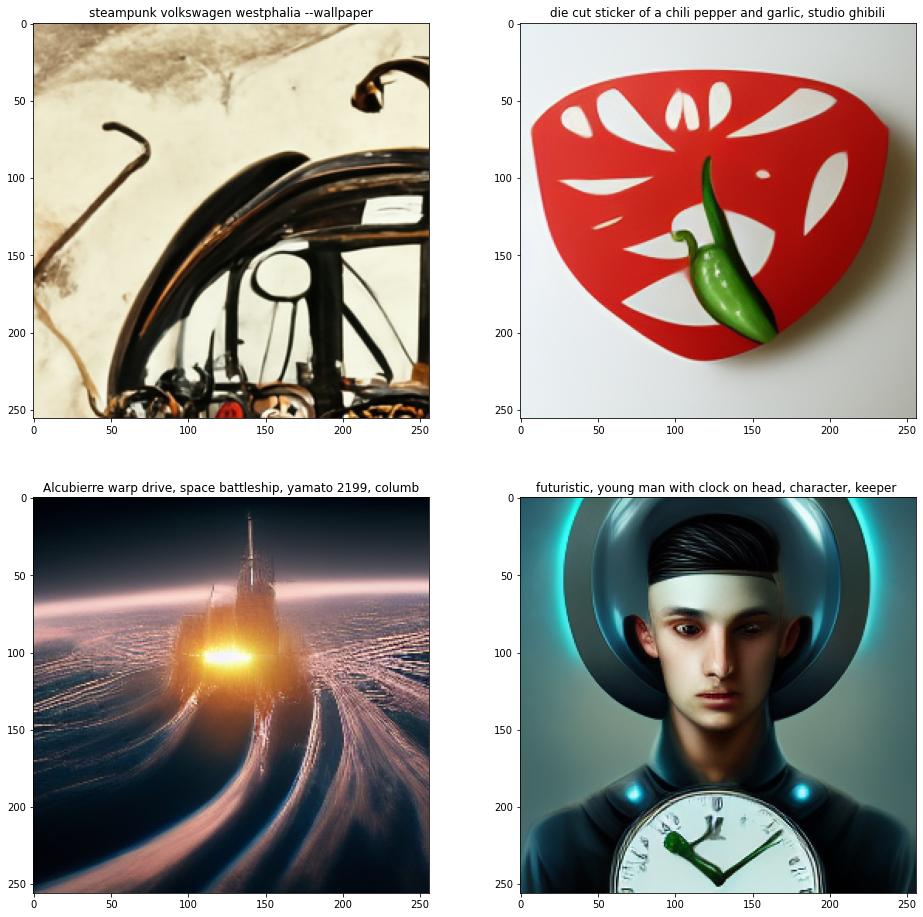

In [ ]:
# take a look at some of the examples
import matplotlib.pyplot as plt

metadata = pd.DataFrame(data_dict)

# show 4 samples
samples = [1925, 1926, 1927, 1928]
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i in range(4):
  prompt = metadata['prompt'][samples[i]]
  img_path = metadata['img'][samples[i]]
  img = np.array(Image.open(img_path))
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(prompt[:60])

plt.show()

# save the metadata
metadata.to_csv('midjourney-prompts-2k.csv', index=False)

## 3. Build the pipeline for stable diffusion

In [ ]:
# first we built a pytorch dataset for this
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import pandas as pd
import numpy as np

class StableDiffusionFinetuneDataset(Dataset):
    def __init__(self, metadata, tokenizer, size=256, split="train"):
        super().__init__()
        self.tokenizer = tokenizer
        self.size = size
        self.metadata = pd.read_csv(metadata)
        self.image_paths = self.metadata['img']
        self.prompts = self.metadata['prompt']
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if split != 'train' else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.image_paths[index])
        text = self.prompts[index]
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt"
        ).input_ids[0]
        return example

In [ ]:
# before the training, let's see how stable diffusion works compared to midjourney groundtruth
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
pretrain_name = 'CompVis/stable-diffusion-v1-4'
clip_tokenizer = CLIPTokenizer.from_pretrained(
    pretrain_name,
    subfolder="tokenizer",
)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'clip_sample': False} were passed to PNDMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

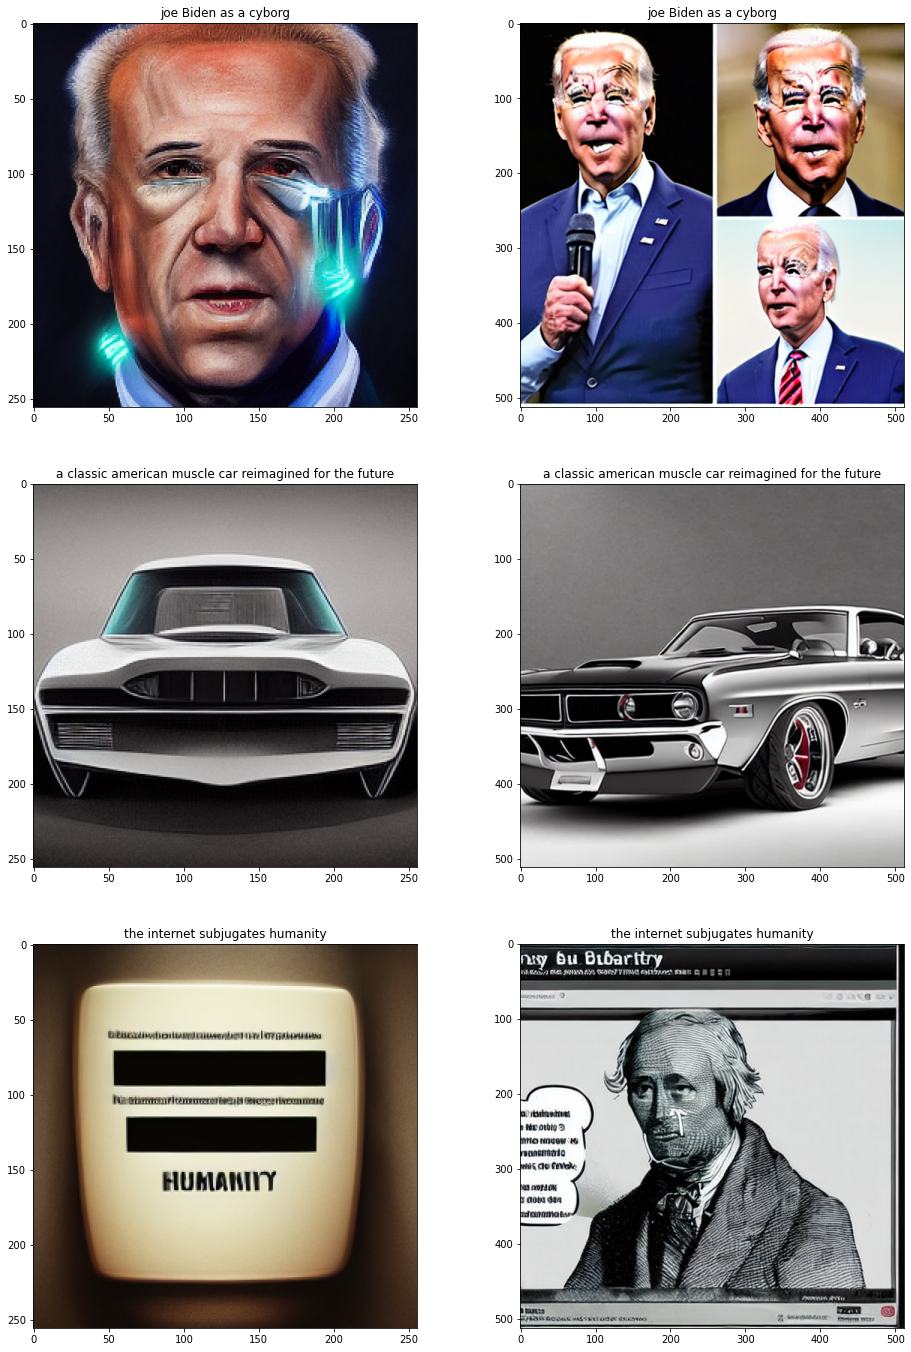

In [ ]:
import matplotlib.pyplot as plt
stable_diffusion_pipeline = StableDiffusionPipeline.from_pretrained(pretrain_name).to(device)

fig, axes = plt.subplots(3, 2, figsize=(16, 24))
for i in range(3):
  j = 798 * i + 3
  text = pd.read_csv('midjourney-prompts-2k.csv')['prompt'][j]
  midjourney_img = np.array(Image.open(f'images/{j}.png'))
  stable_diffusion_img = stable_diffusion_pipeline(text).images[0]
  axes[i][0].imshow(midjourney_img)
  axes[i][1].imshow(stable_diffusion_img)
  axes[i][0].set_title(text[:60])
  axes[i][1].set_title(text[:60])

plt.show()

In [ ]:
# clean the memory
del stable_diffusion_pipeline

In [ ]:
# now we need to define a new tokenizer to include the newly added tokens
# mentioned here: https://midjourney.gitbook.io/docs/user-manual#parameters-to-imagine

midjourney_controls = ['--ar', '--aspect', '--hd', '--beta', '--w', '--h', '--stylize', '--quality', '--chaos', '--uplight']
for new_token in midjourney_controls:
  num_added_tokens = clip_tokenizer.add_tokens(new_token)
  if num_added_tokens == 0:
      raise ValueError(
          f"The tokenizer already contains the token {new_token}. Please pass a different"
          " `placeholder_token` that is not already in the tokenizer."
      )

In [ ]:
# load the diffusion model
# remember to resize the token embedding
text_encoder = CLIPTextModel.from_pretrained(
    pretrain_name, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrain_name, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrain_name, subfolder="unet"
)
text_encoder.resize_token_embeddings(len(clip_tokenizer)) 

# freeze the parameters as we only want to train the text encoder
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
# freeze_params(unet.parameters())

useful resources: 
- DreamBooth: finetune text encoder & Unet: https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py
- Text Inversion: https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb#scrollTo=1_h0kO-VnQog
- Extra control commands in MidJourney: https://midjourney.gitbook.io/docs/user-manual#parameters-to-imagine


In [ ]:
# creating dataset

train_dataset = StableDiffusionFinetuneDataset(metadata='midjourney-prompts-2k.csv', tokenizer=clip_tokenizer)

def create_dataloader(train_batch_size=8):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [ ]:
# Create noise_scheduler for training
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

## 4. Start training!

In [ ]:
safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# Train
# Adaped from https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb#scrollTo=djBS3343sIiY
from diffusers.optimization import get_scheduler

def training_function(text_encoder, vae, unet, hyperparameters):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    num_train_epochs = hyperparameters["num_train_epochs"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    train_dataloader = create_dataloader(train_batch_size)
    max_train_steps = len(train_dataloader) * num_train_epochs // gradient_accumulation_steps

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        itertools.chain(unet.parameters(), text_encoder.parameters()),  # only optimize the embeddings
        lr=learning_rate,
    )

    scheduler = get_scheduler(
        "constant",
        optimizer,
        hyperparameters["lr_warm_up_steps"] * gradient_accumulation_steps,
        max_train_steps * gradient_accumulation_steps
    )

    unet, text_encoder, optimizer, train_dataloader, scheduler = accelerator.prepare(
        unet, text_encoder, optimizer, train_dataloader, scheduler
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    # unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    # unet.eval()


    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["instance_images"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["instance_prompt_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(
                        itertools.chain(unet.parameters(), text_encoder.parameters()), 
                        hyperparameters["max_grad_norm"])
                optimizer.step()
                # scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=clip_tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds_dict = {}
        for placeholder_token in midjourney_controls:
          placeholder_token_id = clip_tokenizer.convert_tokens_to_ids(placeholder_token)
          learned_embeds_dict[placeholder_token_id] = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id].detach().cpu()
        # learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [ ]:
hyperparameters = {
    "learning_rate": 5e-06,
    "scale_lr": True,
    "num_train_epochs": 2,
    "train_batch_size": 8,
    "gradient_accumulation_steps": 1,
    "lr_warm_up_steps": 0,
    "max_grad_norm": 1,
    "seed": 42,
    "output_dir": "sd-concept-output"
}

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet, hyperparameters))

Launching training on one GPU.


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

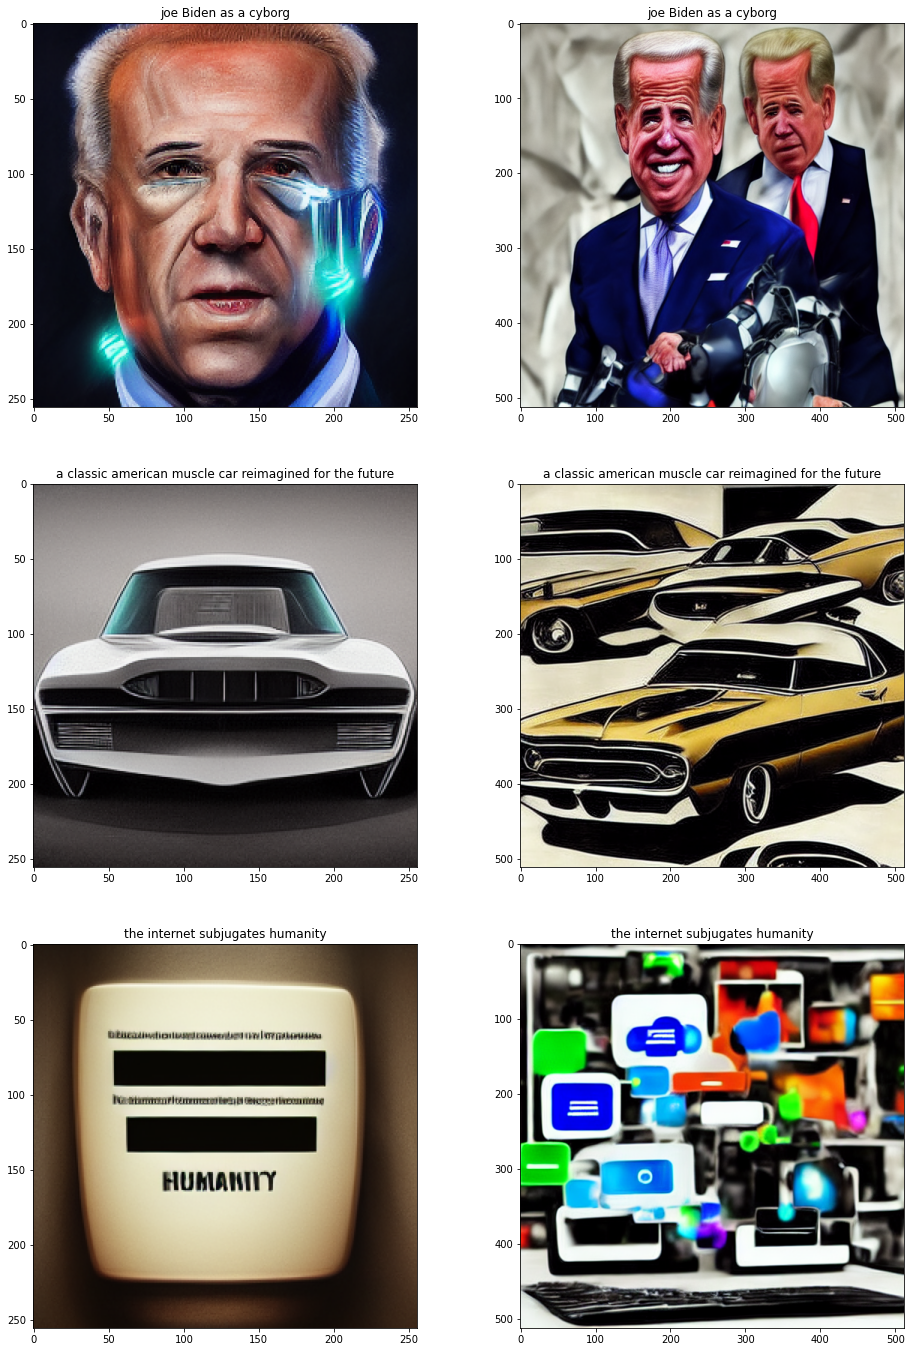

In [ ]:
# now let's see the result of the newly trained pipeline
import matplotlib.pyplot as plt
finetune_pipeline = StableDiffusionPipeline.from_pretrained(hyperparameters['output_dir'], torch_dtype=torch.float16).to(device)
fig, axes = plt.subplots(3, 2, figsize=(16, 24))
for i in range(3):
  j = 798 * i + 3
  text = pd.read_csv('midjourney-prompts-2k.csv')['prompt'][j]
  midjourney_img = np.arraby(Image.open(f'images/{j}.png'))
  finetune_img = finetune_pipeline(text, num_inference_steps=50, guidance_scale=7.5).images[0]
  axes[i][0].imshow(midjourney_img)
  axes[i][1].imshow(finetune_img)
  axes[i][0].set_title(text[:60])
  axes[i][1].set_title(text[:60])
plt.show()

In [ ]:
del finetune_pipeline

# 5 Prefix Tuning 

In this section, instead of finetuning the text encoder and the noise prediction UNet, we are only appending a trainable prefix in the latent space to the input texts. (The prefixes are the same for all of the input texts). 

The new control tokens are also included in this part (we are using the exactly same tokenizer). The embedding for the new control tokens are also trainable.

In [ ]:
# we initialize the prefix as a meaningful sentence
# describing the transition

# first add yet another new token: midjourney
pretrain_name = 'CompVis/stable-diffusion-v1-4'
prefix_tokenizer = CLIPTokenizer.from_pretrained(
    pretrain_name,
    subfolder="tokenizer",
)

midjourney_controls = ['--ar', '--aspect', '--hd', '--beta', '--w', '--h', '--stylize', '--quality', '--chaos', '--uplight']

for new_token in midjourney_controls + ['midjourney']:
  num_added_tokens = prefix_tokenizer.add_tokens(new_token)
  if num_added_tokens == 0:
      raise ValueError(
          f"The tokenizer already contains the token {new_token}. Please pass a different"
          " `placeholder_token` that is not already in the tokenizer."
      )

added_token_ids = prefix_tokenizer.convert_tokens_to_ids(midjourney_controls + ['midjourney'])
print('added token IDs', added_token_ids)

init_prefix_text = "from midjourney style to stable diffusion style"
init_prefix_ids = prefix_tokenizer(
      init_prefix_text,
      padding="do_not_pad",
      truncation=True,
      max_length=prefix_tokenizer.model_max_length,
      return_tensors="pt"
).input_ids[0]

print('initial prefix IDs', init_prefix_ids)

added token IDs [49408, 49409, 49410, 49411, 49412, 49413, 49414, 49415, 49416, 49417, 49418]
initial prefix IDs tensor([49406,   633, 49418,  1844,   531, 10492, 18656,  9364,  1844, 49407])


In [ ]:
# let's build the models from scratch again
text_encoder = CLIPTextModel.from_pretrained(
    pretrain_name, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrain_name, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrain_name, subfolder="unet"
)
text_encoder.resize_token_embeddings(len(prefix_tokenizer)) 

# freeze the parameters as we only want to train the text encoder
def freeze_params(params):
    for param in params:
        param.requires_grad = False

freeze_params(vae.parameters())
freeze_params(unet.parameters())

params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [ ]:
# get the initial prefix embedding
init_prefix_embeddings = text_encoder(init_prefix_ids.unsqueeze(0))[0]
init_prefix_embeddings.shape

torch.Size([1, 10, 768])

In [ ]:
class TextEncoderPrefix(torch.nn.Module):
    def __init__(self, text_encoder, prefix):
        super().__init__()
        self.prefix = torch.nn.Parameter(prefix)
        self.text_encoder = text_encoder

    def forward(self, text):
        embedding = self.text_encoder(text)[0]
        batch_size, seq_len, _ = embedding.shape
        embedding = embedding[:, :seq_len - self.prefix.shape[1], :]
        prefix = self.prefix.repeat(batch_size, 1, 1)
        outputs = torch.cat([prefix, embedding], dim=1)
        return outputs

prefix_text_encoder = TextEncoderPrefix(text_encoder, init_prefix_embeddings.clone())

In [ ]:
safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# training dataset for prefix tuning
prefix_train_dataset = StableDiffusionFinetuneDataset(metadata='midjourney-prompts-2k.csv', tokenizer=prefix_tokenizer)
def create_dataloader_prefix(train_batch_size=8):
    return torch.utils.data.DataLoader(prefix_train_dataset, batch_size=train_batch_size, shuffle=True)

# Create noise_scheduler for training
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

# training function for prefix tuning
def prefix_tuning(prefix_text_encoder, vae, unet, hyperparameters):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    num_train_epochs = hyperparameters["num_train_epochs"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    train_dataloader = create_dataloader_prefix(train_batch_size)
    max_train_steps = len(train_dataloader) * num_train_epochs // gradient_accumulation_steps

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # now the prefix also needs to be optimized
    prefix_embeddings = init_prefix_embeddings.clone()
    prefix_embeddings.requires_grad_(True)
    optimizer = torch.optim.AdamW(
        prefix_text_encoder.parameters(),
        lr=learning_rate,
    )

    scheduler = get_scheduler(
        "constant",
        optimizer,
        hyperparameters["lr_warm_up_steps"] * gradient_accumulation_steps,
        max_train_steps * gradient_accumulation_steps
    )

    prefix_text_encoder, optimizer, train_dataloader, scheduler, prefix_embeddings = accelerator.prepare(
        prefix_text_encoder, optimizer, train_dataloader, scheduler, prefix_embeddings
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()


    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(prefix_train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["instance_images"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = prefix_text_encoder(batch["instance_prompt_ids"])

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = prefix_text_encoder.module.text_encoder.get_input_embeddings().weight.grad
                else:
                    grads = prefix_text_encoder.text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                for placeholder_token_id in added_token_ids:
                    index_grads_to_zero = torch.arange(len(prefix_tokenizer)) != placeholder_token_id
                    grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(
                        text_encoder.get_input_embeddings().parameters(), 
                        hyperparameters["max_grad_norm"])
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=prefix_tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(output_dir)
        torch.save(prefix_text_encoder.prefix, os.path.join(output_dir, 'prefix_text_encoder.pth'))
        # Also save the newly trained embeddings
        learned_embeds_dict = {}
        for placeholder_token in midjourney_controls:
          placeholder_token_id = prefix_tokenizer.convert_tokens_to_ids(placeholder_token)
          learned_embeds_dict[placeholder_token_id] = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id].detach().cpu()
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [ ]:
prefix_tuning_hyperparameters = {
    "learning_rate": 5e-06,
    "scale_lr": True,
    "num_train_epochs": 2,
    "train_batch_size": 8,
    "gradient_accumulation_steps": 1,
    "lr_warm_up_steps": 0,
    "max_grad_norm": 1,
    "seed": 42,
    "output_dir": "prefix-tuning-output"
}

In [ ]:
import accelerate
accelerate.notebook_launcher(prefix_tuning, args=(prefix_text_encoder, vae, unet, prefix_tuning_hyperparameters))

Launching training on one GPU.


  0%|          | 0/590 [00:00<?, ?it/s]

In [ ]:
# Now let's test how this prefix-tuning works
# we have to modify the pipeline a little bit to add the prefix
from diffusers import StableDiffusionPipeline
import os

prefix_pipeline = StableDiffusionPipeline.from_pretrained(prefix_tuning_hyperparameters['output_dir'], torch_dtype=torch.float16).to(device)
trained_prefix = torch.load(os.path.join(prefix_tuning_hyperparameters['output_dir'], 'prefix_text_encoder.pth'))

# print the prefix shape
trained_prefix.shape

torch.Size([1, 10, 768])

In [ ]:
import inspect

def pipeline_with_prefix(pipeline, prompt, prefix, height=256, width=256, num_inference_steps=50, guidance_scale=7.5):
      batch_size = 1

      # get prompt text embeddings
      text_inputs = pipeline.tokenizer(
          prompt,
          padding="max_length",
          max_length=pipeline.tokenizer.model_max_length,
          return_tensors="pt",
      )
      text_input_ids = text_inputs.input_ids
      text_embeddings = pipeline.text_encoder(text_input_ids.to(pipeline.device))[0]

      # duplicate text embeddings for each generation per prompt
      text_embeddings = text_embeddings.repeat_interleave(1, dim=0)
      batch_size, max_len, _ = text_embeddings.shape
      prefix_repeat = prefix.to(pipeline.device).repeat(batch_size, 1, 1)
      text_embeddings = text_embeddings[:, :max_len - prefix_repeat.shape[1], :]
      text_embeddings = torch.cat([prefix_repeat, text_embeddings], dim=1)

      # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
      # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
      # corresponds to doing no classifier free guidance.
      do_classifier_free_guidance = guidance_scale > 1.0
      # get unconditional embeddings for classifier free guidance
      if do_classifier_free_guidance:
          uncond_tokens = [""]
          max_length = text_input_ids.shape[-1]
          uncond_input = pipeline.tokenizer(
              uncond_tokens,
              padding="max_length",
              max_length=max_length,
              truncation=True,
              return_tensors="pt",
          )
          uncond_embeddings = pipeline.text_encoder(uncond_input.input_ids.to(pipeline.device))[0]

          # duplicate unconditional embeddings for each generation per prompt
          uncond_embeddings = uncond_embeddings.repeat_interleave(batch_size * 1, dim=0)

          # For classifier free guidance, we need to do two forward passes.
          # Here we concatenate the unconditional and text embeddings into a single batch
          # to avoid doing two forward passes
          text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

      latents_shape = (batch_size * 1, pipeline.unet.in_channels, height // 8, width // 8)
      latents_dtype = text_embeddings.dtype
      latents = torch.randn(latents_shape, generator=None, device=pipeline.device, dtype=latents_dtype)
      
      # set timesteps
      pipeline.scheduler.set_timesteps(num_inference_steps)

      # Some schedulers like PNDM have timesteps as arrays
      # It's more optimized to move all timesteps to correct device beforehand
      timesteps_tensor = pipeline.scheduler.timesteps.to(pipeline.device)

      # scale the initial noise by the standard deviation required by the scheduler
      latents = latents * pipeline.scheduler.init_noise_sigma

      # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
      # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
      # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
      # and should be between [0, 1]
      accepts_eta = "eta" in set(inspect.signature(pipeline.scheduler.step).parameters.keys())
      extra_step_kwargs = {}
      if accepts_eta:
          extra_step_kwargs["eta"] = 0.0

      for i, t in enumerate(pipeline.progress_bar(timesteps_tensor)):
          # expand the latents if we are doing classifier free guidance
          latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
          latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t)

          # predict the noise residual
          noise_pred = pipeline.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

          # perform guidance
          if do_classifier_free_guidance:
              noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
              noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

          # compute the previous noisy sample x_t -> x_t-1
          latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

      latents = 1 / 0.18215 * latents
      image = pipeline.vae.decode(latents).sample

      image = (image / 2 + 0.5).clamp(0, 1)
      image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
      return image

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

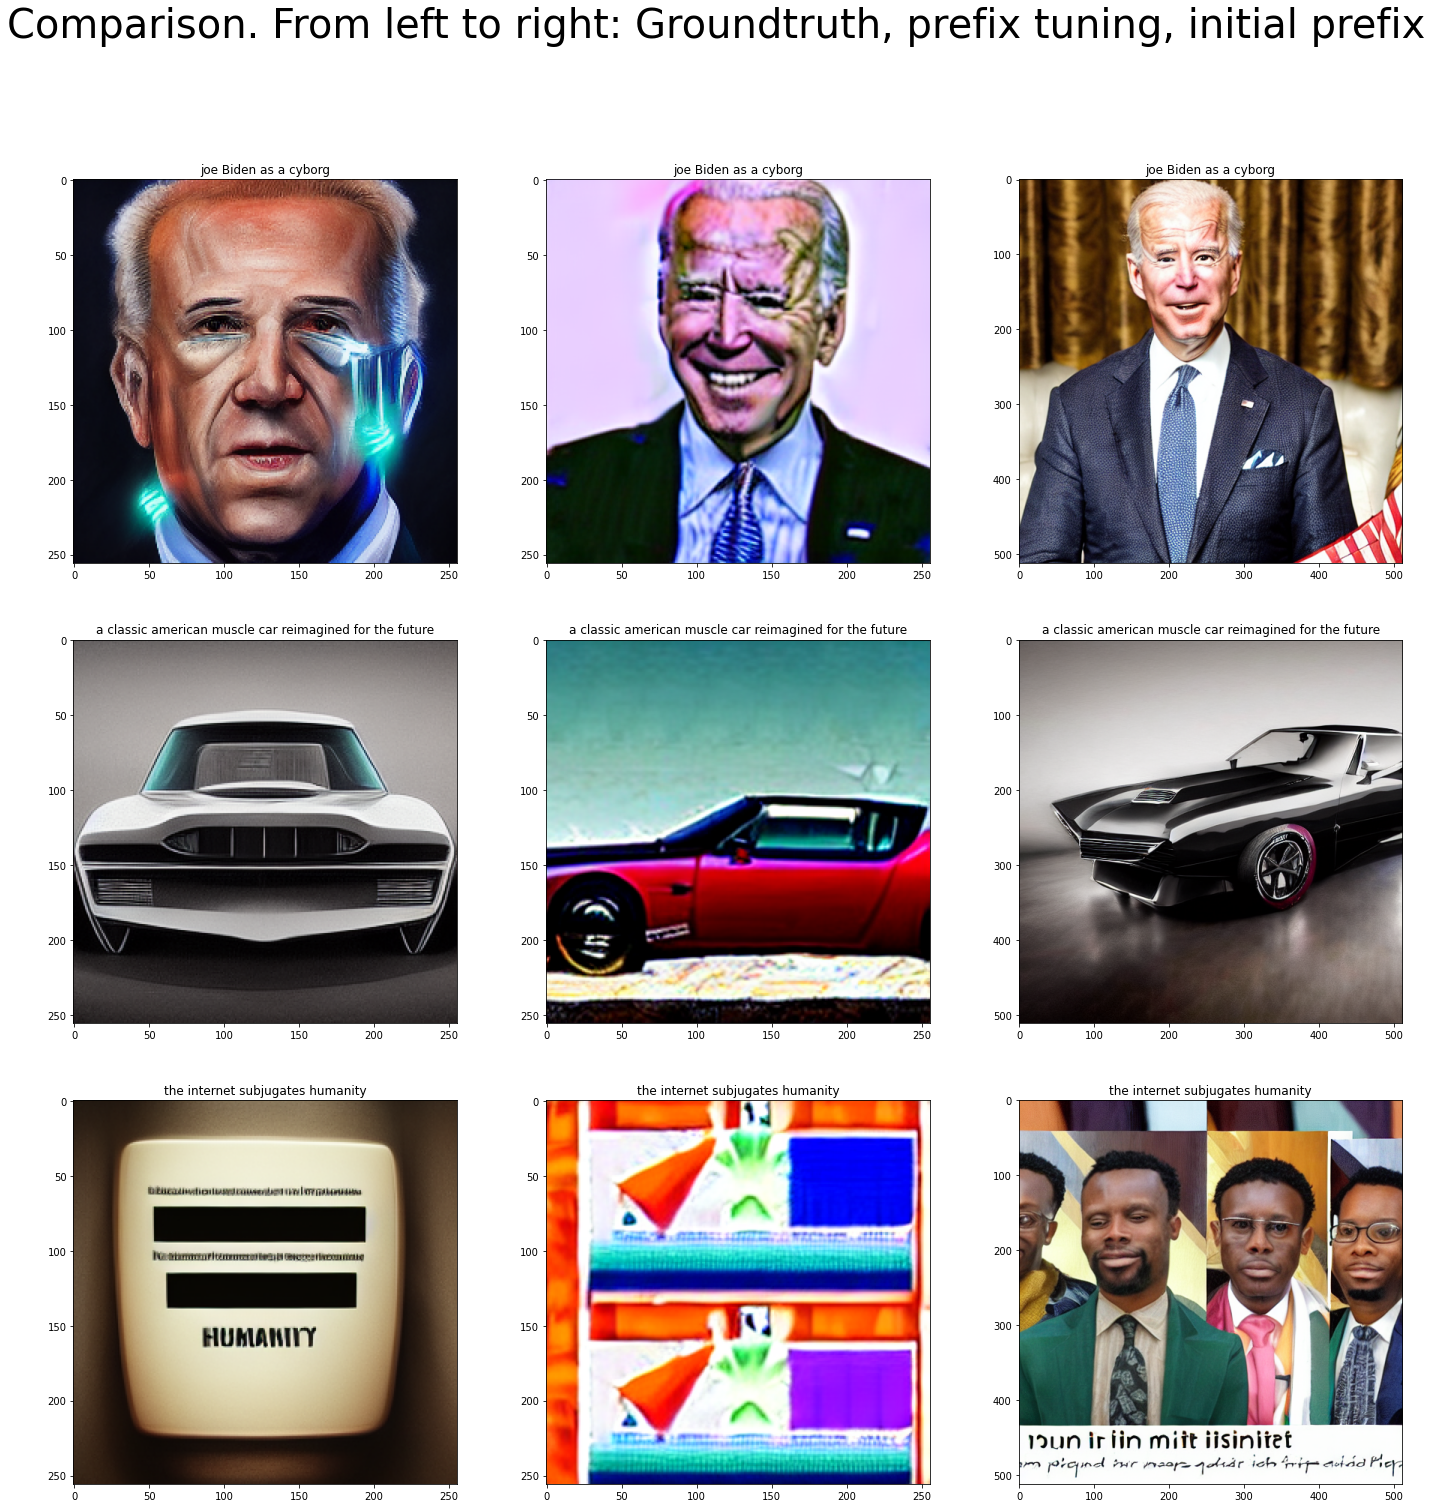

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

torch.cuda.empty_cache()

fig, axes = plt.subplots(3, 3, figsize=(24, 24))
init_prefix_text = "from midjourney style to stable diffusion style"

for i in range(3):
    j = 798 * i + 3
    text = pd.read_csv('midjourney-prompts-2k.csv')['prompt'][j]
    midjourney_img = np.array(Image.open(f'images/{j}.png'))
    prefix_img = pipeline_with_prefix(prefix_pipeline, text, trained_prefix.half())[0].astype(float)
    finetune_img = prefix_pipeline(init_prefix_text + text, num_inference_steps=50, guidance_scale=7.5).images[0]
    axes[i][0].imshow(midjourney_img)
    axes[i][1].imshow(prefix_img)
    axes[i][2].imshow(finetune_img)
    axes[i][0].set_title(text[:60])
    axes[i][1].set_title(text[:60])
    axes[i][2].set_title(text[:60])
plt.suptitle('Comparison. From left to right: Groundtruth, prefix tuning, initial prefix', size=40)
plt.show()

In [ ]:
del prefix_pipeline

## 6. Put them altogether...

In this section, we put together the GPT-2 auto-completion model and the finetuned Stable Diffusion to provide a easy-to-use toolkit for creational workers.

In [ ]:
# for lili and kiki

In [ ]:
!nvidia-smi

Sun Nov 27 00:45:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    49W / 400W |  40386MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------